# Encoder-only Architecture for Text Classification

Recall that the chief reason for using machine learning models over traditional, lexicon-based sentiment analysis is that like lexicon-based approaches to text classifcation rely on fixed dictionaries, which results in them missing context, irony, or slang. ML models, especially deep learning models, learn complex patterns from data, making them particularly useful for more modern text, such as social media posts and online discussions. 


Generally, for text classification tasks, it is faster to use an encoder-only model like BERT, as we don't need to worry about generating some kind of output sequence- all we are doing is classifying text with some pre-defined labels. In other words, our focus is on *understanding* text rather than *generating* text, so it is both faster, and less computationally expensive, to use encoder-only models like BERT. 

In [ ]:
from advanced_encoder_classifier_tests import Tests

## 0. Data Importing and Cleaning

As mentioned, ML-based text classification works the best for nuanced text with lots of slang. Hence, we'll test it on a dataset of recently-scraped *r/UBC* posts. 


```bash
!pip install transformers # you likely don't have this installed.
!pip install pytorch # you likely don't have this installed.
!pip install datasets # you likely don't have this installed.
!pip install evaluate # you likely don't have this installed.
!pip install sentencepiece # you likely don't have this installed.
!pip install accelerate # you likely don't have this installed.
!pip install numpy
!pip install pandas
!pip install seaborn
```

In [11]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
import re
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.preprocessing import MultiLabelBinarizer
import os


In [5]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased") # to break our reddit posts down into tokens
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased") # our model

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\Irene\miniconda3\envs\comet_py\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Irene\.cache\huggingface\hub\models--google-bert--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense

The reddit dataset is dated around late February 2025, however, you are free to scrape newer posts locally by `cd`-ing into the currect directory and running `python project/docs/4_Advanced/advanced_encoder_classifier/r_ubc_scraper.py` in your terminal. This will generate a fresh new set of post/comment datasets for our analysis.

In [6]:
# Load the dataset
reddit_comments = pd.read_csv('Data/r_ubc_comments.csv')
reddit_posts = pd.read_csv("Data/r_ubc_posts.csv")

In [7]:
# Merging datasets
reddit_data = reddit_posts.merge(reddit_comments.groupby("post_id")["body"].apply(lambda x: " ".join(x)), left_on="id", right_on ='post_id', how="left")
reddit_data["full_text"] = reddit_data['title'] + ['    '] + reddit_data["selftext"].fillna('') + ['    '] + reddit_data["body"].fillna('')

In [8]:
# Convert from UTC to detailed month, date, day of week and hour
reddit_data['created_utc'] = pd.to_datetime(
    reddit_data['created_utc'], 
    unit='s',  # Timestamp is in seconds
    utc=True    # Enforce UTC timezone
)

reddit_data['month'] = reddit_data['created_utc'].dt.month_name() 
reddit_data['date'] = reddit_data['created_utc'].dt.day            
reddit_data['day_of_week'] = reddit_data['created_utc'].dt.day_name()  
reddit_data['hour'] = reddit_data['created_utc'].dt.hour    

def clean_text(text):
    if isinstance(text, str):  
        text = text.lower()                         
        text = re.sub(r"http\S+", "", text)         
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  
        return text.strip()                         
    else:
        return ""                      

reddit_data["clean_text"] = reddit_data["full_text"].apply(clean_text)       

## 1. Labelling using a pre-trained roBERTa model

Here we used a pre-trained model from hugging face to generate sentiment labels for each posts. Specifically, we'll be using `cardiffnlp/twitter-roberta-base-sentiment-latest`, a model pre-trained on English twitter texts. It classifies emotions into three categories:  0 -> Negative; 1 -> Neutral; 2 -> Positive.  

If you want to work on datasets containing multiple languages, you can use `google-bert/bert-base-multilingual-uncased`, it is a model pretrained on on the top 102 languages with the largest Wikipedia using a masked language modeling (MLM) objective. You can find more information about it on <https://huggingface.co/google-bert/bert-base-multilingual-uncased>.

In [9]:
emotion_classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest")

reddit_data["sentiment"] = reddit_data["clean_text"].apply(lambda x: emotion_classifier(x[:512])[0]["label"] if pd.notna(x) else "neutral")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Here we are using another pre-trained model to generate topic labels for each posts. Specfically, we are using `cardiffnlp/tweet-topic-base-multilingual`, a model pre-trained on ~198M multilingual tweets and finedtuned for English, Spanish, Japanese, and Greek. You can find information about its labels on <https://huggingface.co/cardiffnlp/tweet-topic-base-multilingual>. 

Unfortunately, there hasn't yet to be a "good" multilingual model for topic classifications for some languages up untill Feburuary 2025, but I believe you can always find something that works for your demand on <https://huggingface.co/models>.

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from scipy.special import expit

MODEL = `"cardiffnlp/tweet-topic-base-multilingual"`
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

class_mapping = model.config.id2label

def classify_text(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    output = model(**tokens)
    
    scores = output[0][0].detach().numpy()
    scores = expit(scores)
    
    predictions = (scores >= 0.5) * 1
    
    # Get predicted labels
    predicted_labels = [class_mapping[i] for i in range(len(predictions)) if predictions[i]]
    
    return ", ".join(predicted_labels) if predicted_labels else "other"

reddit_data["topic"] = reddit_data["clean_text"].apply(classify_text)

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

c:\Users\Irene\miniconda3\envs\comet_py\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Irene\.cache\huggingface\hub\models--cardiffnlp--tweet-topic-base-multilingual. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [8]:
def clean_topics(topic_list):
    if isinstance(topic_list, list):
        return [topic.strip() for topic in topic_list]
    return topic_list 

reddit_data["topics"] = reddit_data["topic"].apply(lambda x: x.split(","))

reddit_data["topics"] = reddit_data["topics"].apply(clean_topics)

In [9]:
reddit_data["multi_labels"] = reddit_data.apply(lambda row: row["topics"] + [row["sentiment"]], axis=1)

reddit_data["multi_labels"] = reddit_data["multi_labels"].apply(lambda x: eval(x) if isinstance(x, str) else x)

reddit_data.to_csv('Data/r_reddit_data.csv', index=False)

Since we saved the dataframe as a csv, we are now able to begin from this step by reading the csv file directly.

In [ ]:
# Split training and testing data
# You can start from this step if you don't want to re-generate emotion and topic labels
reddit_data = pd.read_csv("Data/r_reddit_data.csv")

train_indices, test_indices = train_test_split(reddit_data.index, test_size=0.2, random_state=114514) # We set seed to ensure reproducible results
 
train_data = reddit_data.loc[train_indices].reset_index(drop=True)
test_data = reddit_data.loc[test_indices].reset_index(drop=True)

We can visualize the share of different labels with a pie chart.

In [11]:
# Print the distribution table of labels

train_data["topics"] = train_data["topics"].apply(lambda x: eval(x) if isinstance(x, str) else x)
test_data["topics"] = test_data["topics"].apply(lambda x: eval(x) if isinstance(x, str) else x)

train_data["topics"] = train_data["topics"].apply(clean_topics)
test_data["topics"] = test_data["topics"].apply(clean_topics)

train_exploded = train_data.explode("topics")
test_exploded = test_data.explode("topics")

train_counts = train_exploded["topics"].value_counts()
test_counts = test_exploded["topics"].value_counts()

distribution_df = pd.DataFrame({
    "train_count": train_counts,
    "test_count": test_counts
}).fillna(0).astype(int)

distribution_df["train %"] = (distribution_df["train_count"]/distribution_df["train_count"].sum() * 100).round(2)
distribution_df["test %"] = (distribution_df["test_count"]/distribution_df["test_count"].sum() * 100).round(2)

distribution_df.sort_values(by="train_count", ascending=False, inplace=True)

display(distribution_df)

,train_count,test_count,train %,test %
topics,,,,
diaries_&_daily_life,523,133,31.64,32.76
learning_&_educational,330,83,19.96,20.44
youth_&_student_life,288,69,17.42,17.00
news_&_social_concern,155,39,9.38,9.61
relationships,66,11,3.99,2.71
science_&_technology,54,11,3.27,2.71
business_&_entrepreneurs,50,8,3.02,1.97
fitness_&_health,34,9,2.06,2.22
other_hobbies,28,6,1.69,1.48


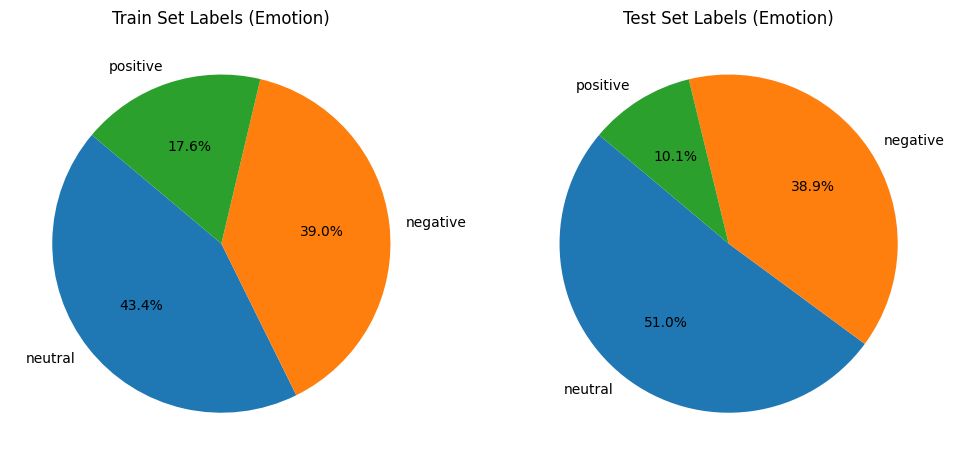

<Figure size 1200x900 with 0 Axes>

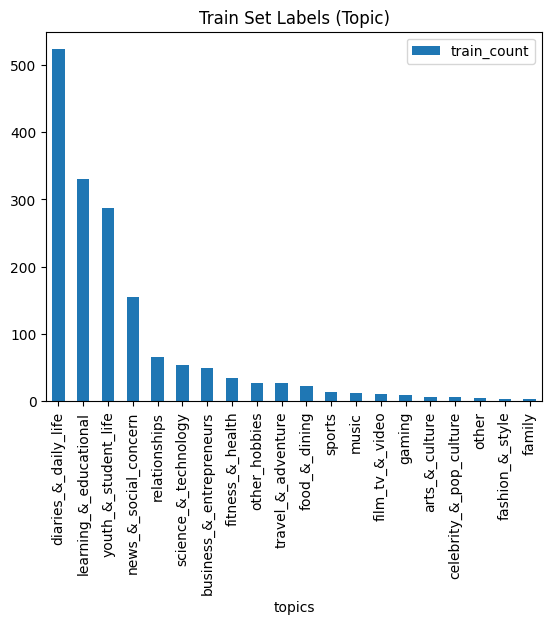

<Figure size 1200x900 with 0 Axes>

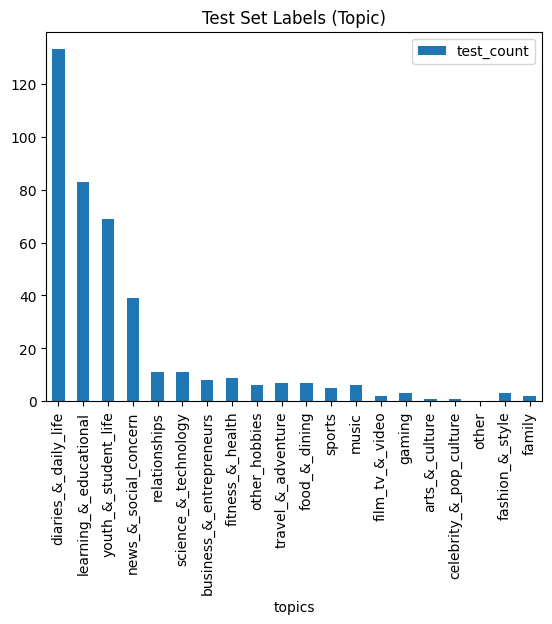

In [12]:
# Plot the Pie Chart
train_emotion_counts = pd.Series(train_data["sentiment"]).value_counts()
test_emotion_counts = pd.Series(test_data["sentiment"]).value_counts()

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
train_emotion_counts.plot.pie(autopct='%1.1f%%', startangle=140, title="Train Set Labels (Emotion)")
plt.ylabel('')

plt.subplot(1,2,2)
test_emotion_counts.plot.pie(autopct='%1.1f%%', startangle=140, title="Test Set Labels (Emotion)")
plt.ylabel('')

plt.show()

plt.figure(figsize=(12, 9))
distribution_df.plot.bar(y = "train_count", title="Train Set Labels (Topic)")
plt.ylabel('')

plt.show()

plt.figure(figsize=(12, 9))
distribution_df.plot.bar(y = "test_count", title="Test Set Labels (Topic)")
plt.ylabel('')

plt.show()

Then we can preprocess our data by binarizing the unique labels and tokenize our columns for classification.

### Question 1

Out of the options below, which one is not a strength of using encoder only model for classification? 

- A) It is relatively cheaper to train.
- B) It can generate labels itself even if no pre-defined label is attached to training texts.
- C) It can overcome missing context, irony or slang.
- D) It works well with multi-label tasks.
- E) None of the above. 

*Enter your answer below as a a string with one of A, B, C, D, E ie. "A"*

In [ ]:
answer1 = # Your answer here 

Tests.test1(answer1)

## 2. Training Classifiers

### 1. OneVsRestClassifier

This is our first classifying strategy, which consists in fitting one binary classifier per class.

For example, if you want to classify 3 types of fruits, apple, banana and orange with this strategy, you will need to train 3 binary classifiers. The first of these classifiers determines if it is an apple, the second is responsible for determining if it is a banana, and the third is responsible for determining if it is an orange.

The 3 classifiers will then vote for the given new observation, the voting result will be shown as probability. Let's say we have a new observation that we are unsure what type of fruit it is, so we feed this observation to our classifier. The "Apple" classifier claims it's 80% likely an apple, the "Banana" classifier claims it's 10% likely a banana, and the "Orange" classifier claims it's 50% likely an orange. Then we classify based on the highest probability that our new object is an apple.

While it is simple and effective, this strategy has its drawback -- What if there are large amount of labels for us to classify? What if the labels have specific hierarchies? In the first situation, it may take a lot of time to train multiple classifiers for this task; and in the second situation, we could make a lot of mistakes using binary classification. Then we'd better use alternative strategies. 

Anyhow, this is a good way to begin encoder classification.

### 2. MultiOutputClassifier 

This strategy consists of fitting one classifier per target. This is a simple strategy for extending classifiers that do not natively support multi-target classification. 

It is somewhat similar to the *OneVsRest* strategy we just described, but uses a different approach. Let's go back to the fruit classification example, where in the previous setup we trained 3 different classifiers for 3 different types of fruits. Now, let's say that we basically determine which type of fruit it is by looking at the multiple features shared by these fruits (e.g., color, smoothness, and flavor). Then, the *MultiOutput* strategy would train a classifier to specialize in one variable. 

You may have noticed that this overcomes the shortcomings of the *OneVsRest* strategy to a certain extent, especially when there are more “labels” than training variables. However, when we have more variables than labels, this strategy is less efficient than the *OneVsRest* strategy. Therefore, we need to be cautious when choosing our strategy. 

### 3. ClassifierChain

We are finally coming to our last strategy -- It is to train multi-label model that arranges binary classifiers into a chain.  

I'll stick with the fruit categorization example (because it's simple and straightforward), and assume that we've used a *MultiOutput* strategy, which provides us with 3 classifiers that deal with 3 different features of the fruit. How can we make them work more efficiently? We want them to work in a band, rather than individually! A *ClassifierChain* can also treat the evidence found by the previous classifier as a feature for the next one, thus improving the quality of the classification by sharing common knowledge and "pass on" the evidence chain.

While this strategy sounds smarter than the first two, it has its drawbacks. First, it is more prone to false correlation and over-fitting. Second, it requires more resources to train. Third, when there are fewer covariates, the improvement that this strategy may bring is not significant. Therefore, special care should be taken when deciding to adopt this strategy!

Now that we've finished this short tutorial on 3 different classification strategies, we will show how to train a basic encoder classifier for multi-label task with an example.

### Question 2

Suppose that a hospital is developing a system to automatically classify patient symptoms into multiple diagnostic categories. Each patient might have 0-3 simultaneous conditions from 15 possible diseases. Doctors observe that certain conditions often co-occur (e.g., diabetes and hypertension). Which strategy would BEST leverage these inter-label relationships while maintaining reasonable computational efficiency?

- A) *OneVsRest* 
- B) *MultiOutput* 
- C) *ClassifierChain*
- D) None of the above

*Enter your answer below as a a string with one of A, B, C, D, ie. "A"*

In [ ]:
answer2 = # Your answer here 

Tests.test2(answer2)

## 3. Training a Multi-Label Classifier on Reddit Data

Now that we've gone over the various classifying strategies, we'll try and train a new classifier on the labels produced by `cardiffnlp/tweet-topic-base-multilingual`. Specifically, we'll train a bert model on the synthetic labels on the reddit dataset we generated earlier. Training on synthetic data, data generated by other ML models, is a valid technique. In fact, [researchers estimate that new human-generated data for training ML models will run out within the next 2 to 8 years, forcing the use of synthetic data for training.](https://arxiv.org/pdf/2211.04325). There are, of course, obvious downsides; in a classification context, the biases present in the classifications of one model will be transferred over to any models trained on the upstream model's classifications. However, for learning purposes, this method works well and is cost-effective, as the code below can easily be modified and reused for human-labeled datasets. 

Our workflow will consist of the following:

1) Convert labels into matrices of binary values.
2) Tokenize our `clean_data` column into tokens for classification.
3) Define/discuss accuracy, recall, and reate a function for evaluating our model's predictions. 
4) Train and test our model!

We'll accomplish this primarily with the use of two libraries: `skit-learn` and `transformers`. `skit-learn` provides us a convenient way of transforming our labels into binary vectors, while the `transformers` library abstracts most of the training and evaluation into simpler code.

### 3.1 Data-preprocessing

We'll start by doing some simple data preprocessing and setting up our GPU. 

<alert>
You'll probably want a CUDA-compatible GPU for this. Consider google collab for smaller datasets.
</alert>

In [ ]:
os.environ["WANDB_DISABLED"] = "true" # disables annoying API key requirement
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Best to have a GPU.
model.to(device)

train_dataset = train_data[['clean_text', 'multi_labels']]
test_dataset = test_data[['clean_text', 'multi_labels']]# clean_text is our textual input, 'multi_labels' is our list of labels.
print(train_dataset)

Notice that the multi-label column is comprised of lists of labels. Each list corresponds to the series of labels assigned to each reddit post. While this is intuitive for us to understand, it is not so intuitive for our model. So, we'll need to convert it into a format easily interpretable by a computer: a binary vector. Each value in the vector corresponds to the presence of one of the 81 labels in our dataset. Repeating this for all n rows of the dataset, we end up with a matrix of size $700 \times 81$. We'll do this conversion using `sklean`'s [MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) class.

In [ ]:

mlb = MultiLabelBinarizer()

train_labels = mlb.fit_transform(train_data['multi_labels'])  
test_labels  = mlb.transform(test_data['multi_labels'])  
num_labels = train_labels.shape[1]

train_data = train_data.copy()
test_data  = test_data.copy()
train_data['labels_encoded'] = list(train_labels)
test_data['labels_encoded']  = list(test_labels)

# Converting the pandas DataFrames into HuggingFace Datasets, in order to use the trainer.
train_dataset = Dataset.from_pandas(train_data[['clean_text', 'labels_encoded']])
test_dataset  = Dataset.from_pandas(test_data[['clean_text', 'labels_encoded']])

In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(batch):
    encoding = tokenizer(batch["clean_text"], truncation=True, padding='max_length', max_length=128)
    encoding["labels"] = [[float(x) for x in label_list] for label_list in batch["labels_encoded"]]
    return encoding

In [ ]:

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset  = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(["clean_text", "labels_encoded"])
test_dataset  = test_dataset.remove_columns(["clean_text", "labels_encoded"])

train_dataset.set_format("torch")
test_dataset.set_format("torch")

In [ ]:

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    num_labels=num_labels, 
    problem_type="multi_label_classification" 
)

In [ ]:

def compute_metrics(p):
    logits, labels = p
    probs = 1 / (1 + np.exp(-logits))
    # Threshold at 0.5 to get binary predictions.
    preds = (probs >= 0.5).astype(int)
    # Compute binary accuracy: average over all label predictions.
    binary_accuracy = np.mean(preds == labels)
    true_positives = np.logical_and(preds == 1, labels == 1).sum()
    total_actual   = (labels == 1).sum()
    micro_recall = true_positives / total_actual if total_actual > 0 else 0  
    
    return {"binary_accuracy": binary_accuracy, "micro_recall": micro_recall}

In [ ]:

training_args = TrainingArguments(
    output_dir="./results",          
    evaluation_strategy="epoch",     
    num_train_epochs=3,              
    per_device_train_batch_size=3,    
    per_device_eval_batch_size=3,     
    learning_rate=2e-5,               
    weight_decay=0.01,               
    logging_steps=10,                
    load_best_model_at_end=True,     
    metric_for_best_model="binary_accuracy", 
    save_total_limit=2,              
    save_strategy="epoch"
)

In [ ]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# This call will run the full training loop
trainer.train()

results = trainer.evaluate()
print(results)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# calculate confusion matrix
y_true = test_data["label"]
y_pred = model.predict(test_data["text"])

# sort labels
classes = sorted(set(y_true)) 

cm = confusion_matrix(y_true, y_pred, labels=classes)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="gray", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

By looking at this confusion matrix and the classification report, we now realize a key disadvantage of our current model lies in correctly classifying anger.

Another way of checking is to look at the baseline model accuracy 

In [ ]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="stratified")
dummy.fit(train_data["text"], train_data["label"])
baseline_acc = dummy.score(test_data["text"], test_data["label"])
print(f'Baseline Model Accuracy: {baseline_acc:.4f}')

In our case, we see the baseline model accuracy is 0.3889, therefore, our training model made about 0.27 accuracy improvement from the base model.

## Reference